In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/cleaned_airbnb.csv')

In [3]:
df.head()

,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,days_since_last_review,price_bin,price_per_day,is_premium,price_log
0,"Romantic, stylish B&B houseboat in canal district",97647,Centrum-West,52.38761,4.89188,Private Room,132.0,3,302,2025-06-11,1.85,1,53,28,21.0,$101 -200,2.444444,False,4.890349
1,Comfortable double room,124245,Centrum-West,52.36775,4.89092,Private Room,78.0,2,710,2025-06-16,3.93,2,130,93,16.0,$51-100,0.595420,False,4.369448
2,Comfortable single / double room,124245,Centrum-Oost,52.36584,4.89111,Private Room,70.0,2,822,2025-06-14,4.74,2,121,86,18.0,$51-100,0.573770,False,4.262680
3,Quiet 2-bedroom Amsterdam city centre apartment,194779,Centrum-Oost,52.37168,4.91471,Entire Home,223.0,3,42,2022-08-20,0.23,1,0,0,1047.0,$201-500,223.000000,False,5.411646
4,Charming apartment in old centre,211696,De Baarsjes - Oud-West,52.36786,4.87458,Entire Home,120.0,2,203,2025-05-29,1.13,1,66,5,34.0,$101 -200,1.791045,False,4.795791


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10168 entries, 0 to 10167
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            10168 non-null  object 
 1   host_id                         10168 non-null  int64  
 2   neighbourhood                   10168 non-null  object 
 3   latitude                        10168 non-null  float64
 4   longitude                       10168 non-null  float64
 5   room_type                       10168 non-null  object 
 6   price                           10168 non-null  float64
 7   minimum_nights                  10168 non-null  int64  
 8   number_of_reviews               10168 non-null  int64  
 9   last_review                     9198 non-null   object 
 10  reviews_per_month               10168 non-null  float64
 11  calculated_host_listings_count  10168 non-null  int64  
 12  availability_365                

In [6]:
#features
features = [
    'minimum_nights', 'number_of_reviews', 'reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'number_of_reviews_ltm', 'days_since_last_review', 'price_per_day']

In [7]:
X = df[features]
y = df['price_log']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline_rf.fit(X_train, y_train)

,steps,"[('scaler', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2


In [10]:
import numpy as np

y_pred = pipeline_rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Random Forest Performance:
RMSE: 0.1090
MAE: 0.0197
R² Score: 0.9431


In [11]:
#cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline_rf, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(cv_rmse)
print(f"Cross-validated RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")

[0.10663613 0.03958096 0.07274866 0.0478052  0.07013272]
Cross-validated RMSE: 0.0674 ± 0.0234


In [12]:
#hyper parameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}


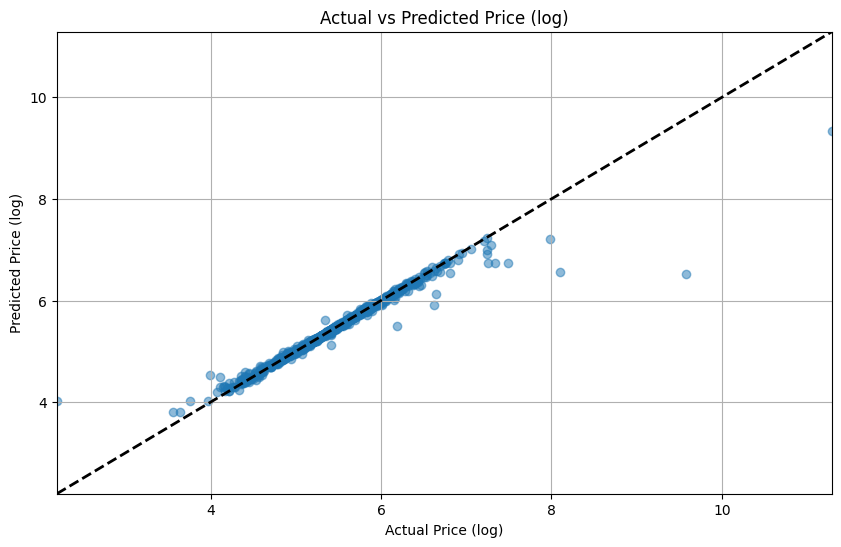

In [15]:
#model prediction graph
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Price (log)')
plt.ylabel('Predicted Price (log)')
plt.title('Actual vs Predicted Price (log)')
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.grid()
plt.show()


[0.00074041 0.00659975 0.0016827  0.00361135 0.32398515 0.00217985
 0.00161918 0.6595816 ]


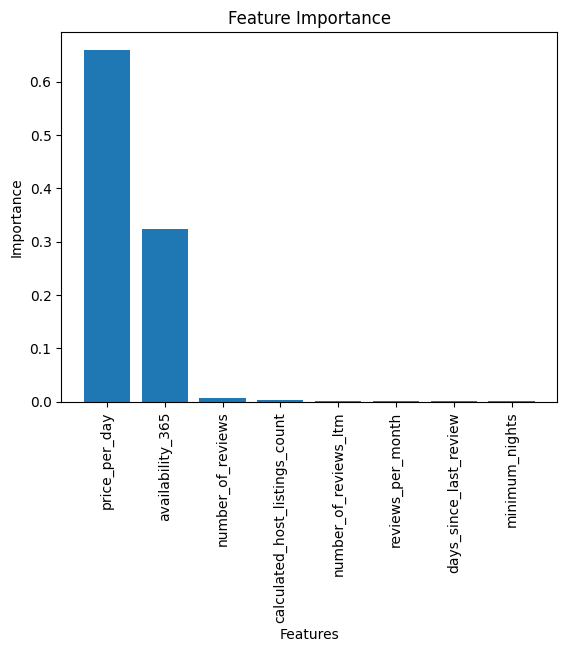

In [16]:
#feature importance
importances = pipeline_rf.named_steps['rf'].feature_importances_
print(importances)
feature_names = X.columns
indices = np.argsort(importances)[::-1]
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), feature_names[indices], rotation=90)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [17]:
import joblib as jb
# Save the model
jb.dump(pipeline_rf,'../models/random_forest_model.pkl')

['../models/random_forest_model.pkl']